In [2]:
# Regression Models
%matplotlib inline
#%matplotlib widget
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor,
RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, StratifiedKFold, 
RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [3]:
#columns_to_import = ['hour_of_day',	'cash_type', 'card', 'money', 'coffee_name',
#                     'Time_of_Day',	'Weekday', 'Month_name', 'Weekdaysort',	'Monthsort']

df = pd.read_excel('Coffe_sales.xlsx')
df.head()

,date,datetime,hour_of_day,cash_type,card,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort
0,2024-03-01,2024-03-01 10:15:50.520,10,card,ANON-0000-0000-0001,38.7,Latte,Morning,Fri,Mar,5,3
1,2024-03-01,2024-03-01 12:19:22.539,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3
2,2024-03-01,2024-03-01 12:20:18.089,12,card,ANON-0000-0000-0002,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3
3,2024-03-01,2024-03-01 13:46:33.006,13,card,ANON-0000-0000-0003,28.9,Americano,Afternoon,Fri,Mar,5,3
4,2024-03-01,2024-03-01 13:48:14.626,13,card,ANON-0000-0000-0004,38.7,Latte,Afternoon,Fri,Mar,5,3


In [4]:
# Lowering columns
df.columns = df.columns.str.lower() 

In [5]:
# Drop columns
df.drop(columns=['date','card','datetime'], inplace=True)

In [7]:
df.rename(columns={'money':'price', 'weekdaysort':'weekday_encoded', 
                   'monthsort':'month_encoded'}, inplace=True)

In [9]:
df.drop(columns=['weekday','month_name'], inplace=True)

In [11]:
df['cash_type'].unique()

array(['card', 'cash'], dtype=object)

In [12]:
df['time_of_day'].unique()

array(['Morning', 'Afternoon', 'Night'], dtype=object)

In [13]:
df['coffee_name'].unique()

array(['Latte', 'Hot Chocolate', 'Americano', 'Americano with Milk',
       'Cocoa', 'Cortado', 'Espresso', 'Cappuccino'], dtype=object)

In [14]:
print(f"Dataframe's shape: {df.shape}\n")
print({df.info(memory_usage='deep')})
print(f"\nColumns to list {df.columns.tolist()}\n")
display(f"Dataframe's distribution:", df.describe())

Dataframe's shape: (3636, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hour_of_day      3636 non-null   int64  
 1   cash_type        3636 non-null   object 
 2   price            3636 non-null   float64
 3   coffee_name      3636 non-null   object 
 4   time_of_day      3636 non-null   object 
 5   weekday_encoded  3636 non-null   int64  
 6   month_encoded    3636 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 797.0 KB
{None}

Columns to list ['hour_of_day', 'cash_type', 'price', 'coffee_name', 'time_of_day', 'weekday_encoded', 'month_encoded']



"Dataframe's distribution:"

,hour_of_day,price,weekday_encoded,month_encoded
count,3636.000000,3636.000000,3636.000000,3636.000000
mean,14.166942,31.746859,3.847910,6.394664
std,4.227755,4.919926,1.975983,3.480686
min,6.000000,18.120000,1.000000,1.000000
25%,10.000000,27.920000,2.000000,3.000000
50%,14.000000,32.820000,4.000000,6.000000
75%,18.000000,35.760000,6.000000,10.000000
max,22.000000,40.000000,7.000000,12.000000


In [21]:
#df['coffee_name'].value_counts()

In [15]:
df.isnull().sum()

hour_of_day        0
cash_type          0
price              0
coffee_name        0
time_of_day        0
weekday_encoded    0
month_encoded      0
dtype: int64

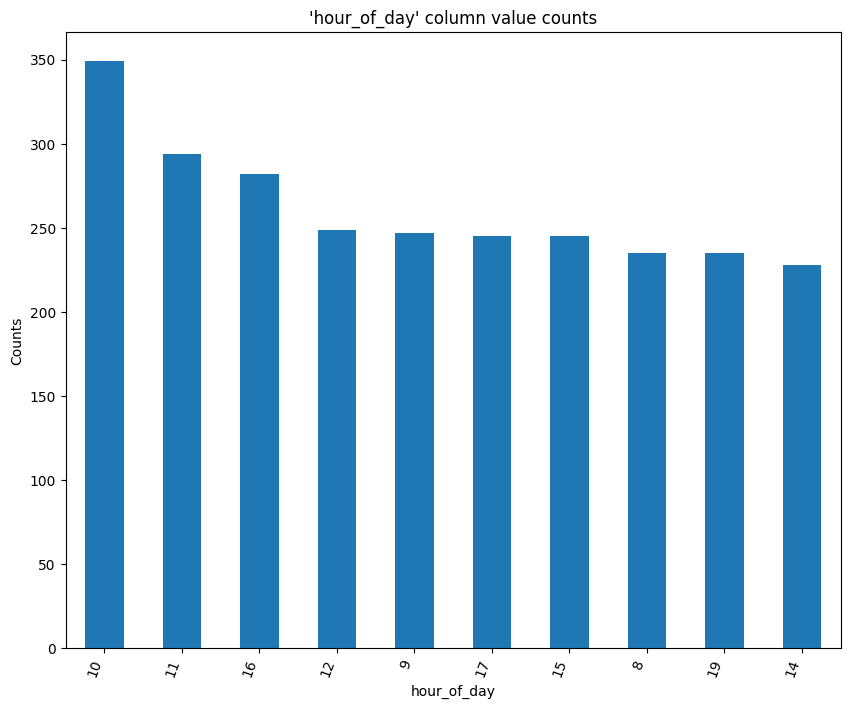

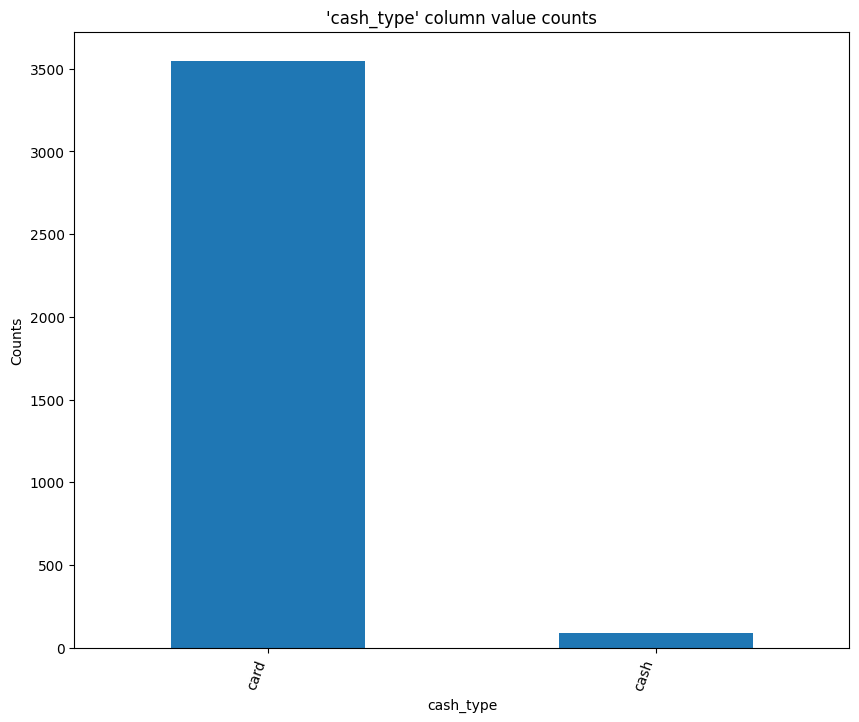

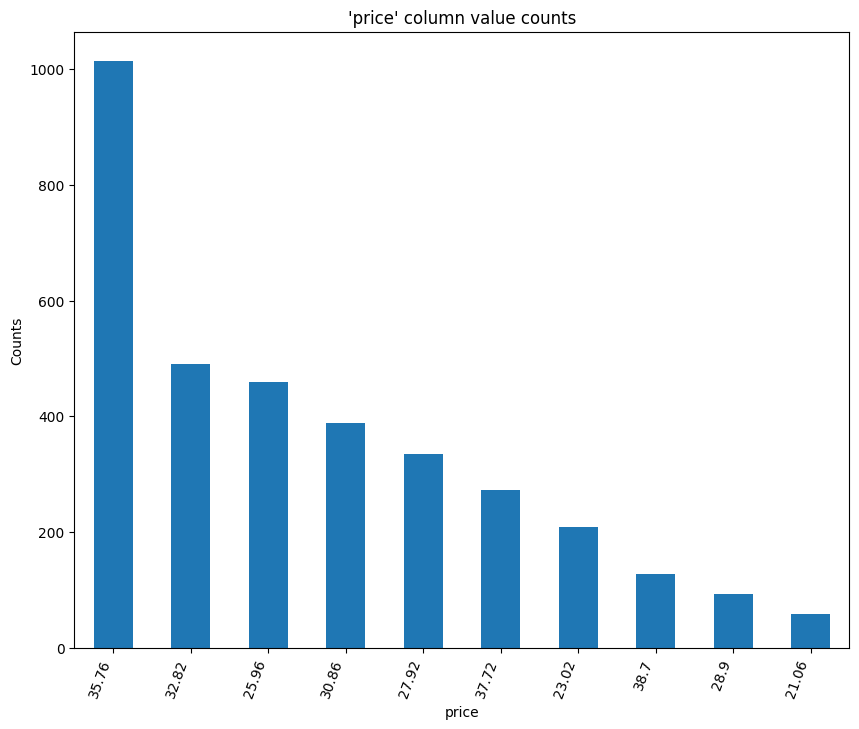

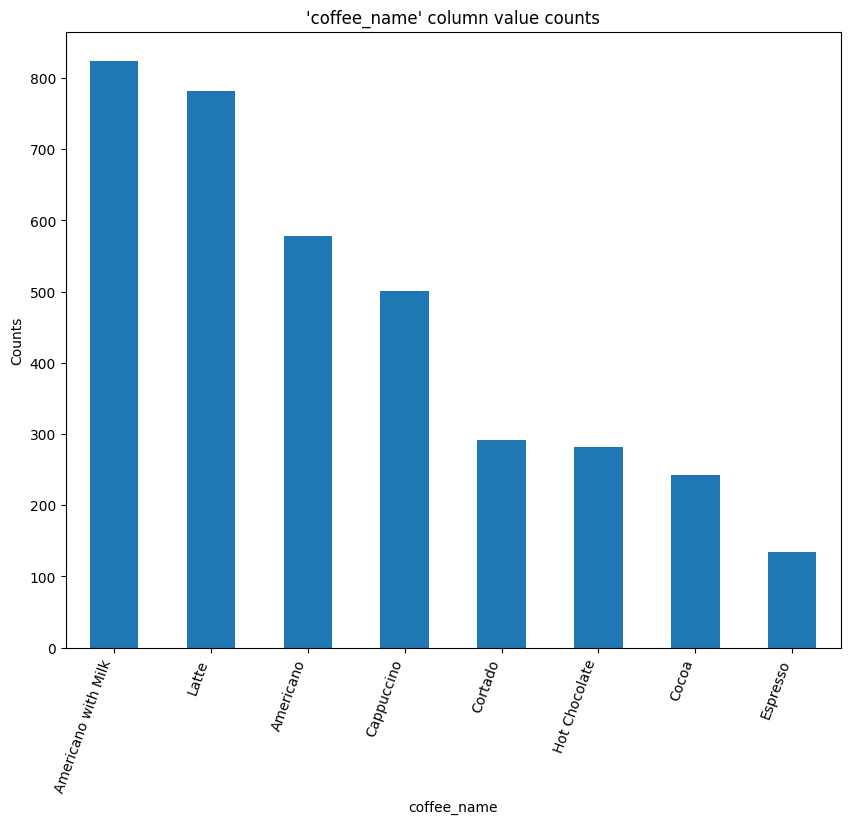

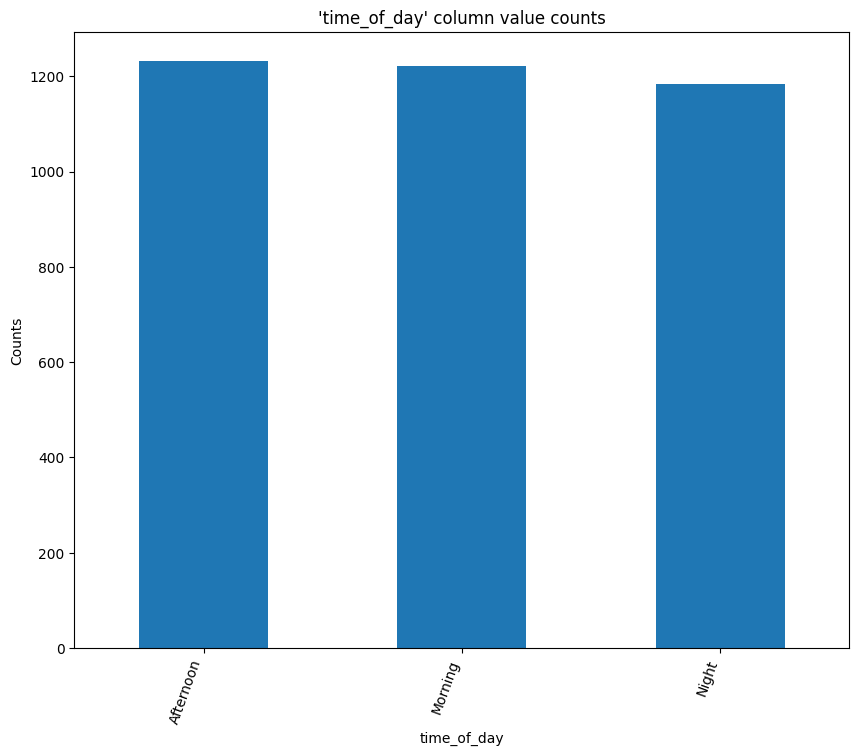

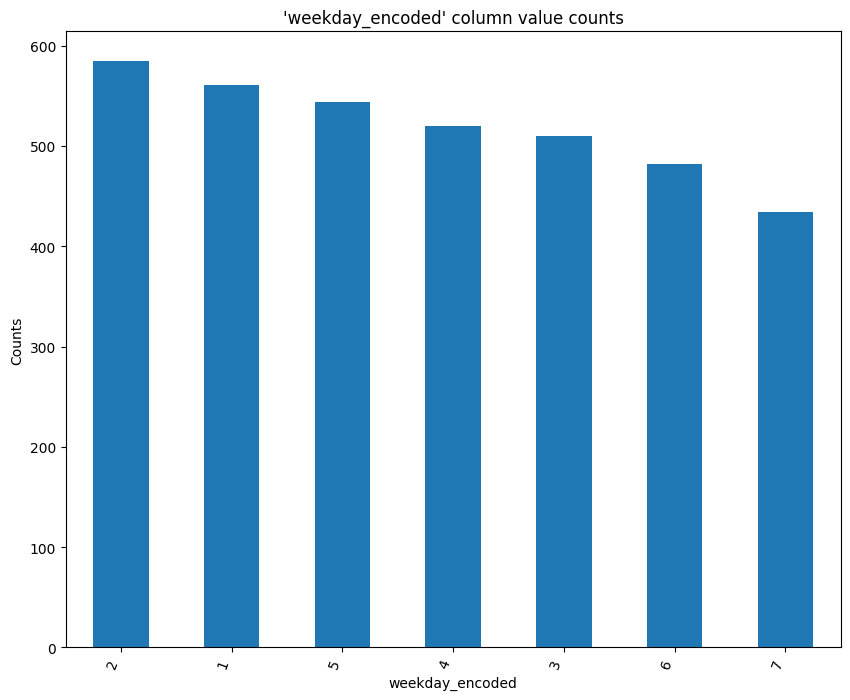

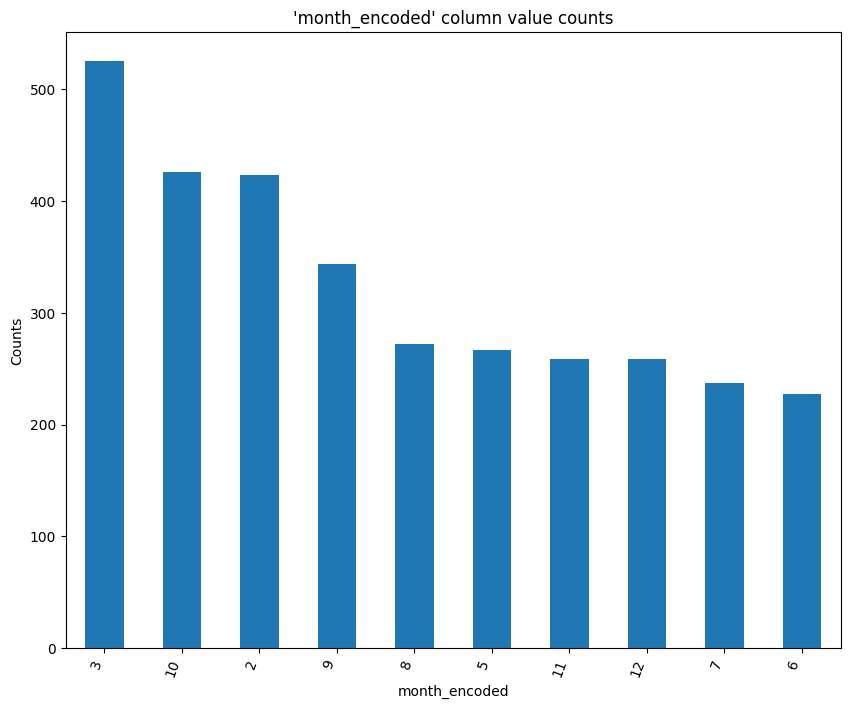

In [16]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

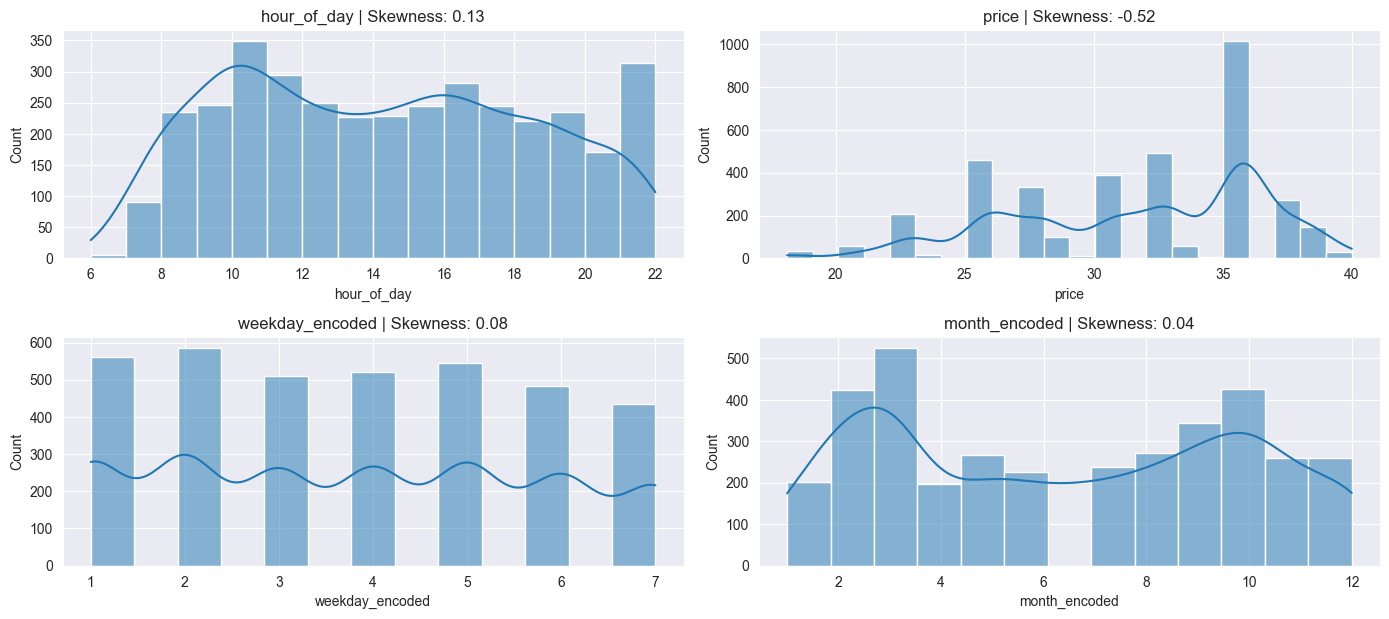

In [17]:
# 2. Kernel density plot for understanding variance in the dataset
sns.set_style("darkgrid")
numerical_columns = df.select_dtypes(include=["int", "float"]).columns
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

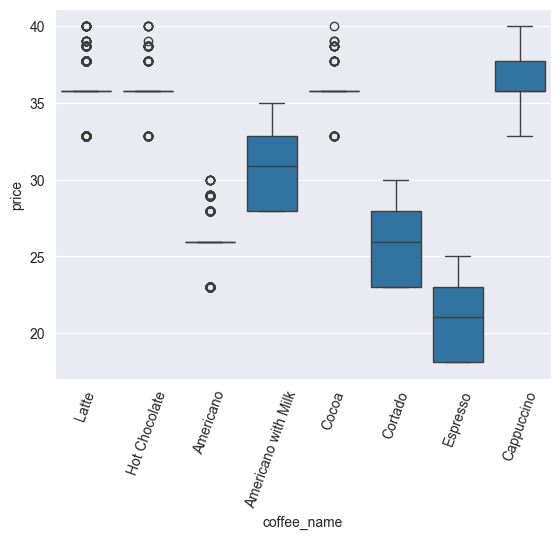

In [18]:
# Box Plot for examining the relationship between coffee_name and price
sns.boxplot(x='coffee_name', y='price', data=df)
plt.xticks(rotation=70);

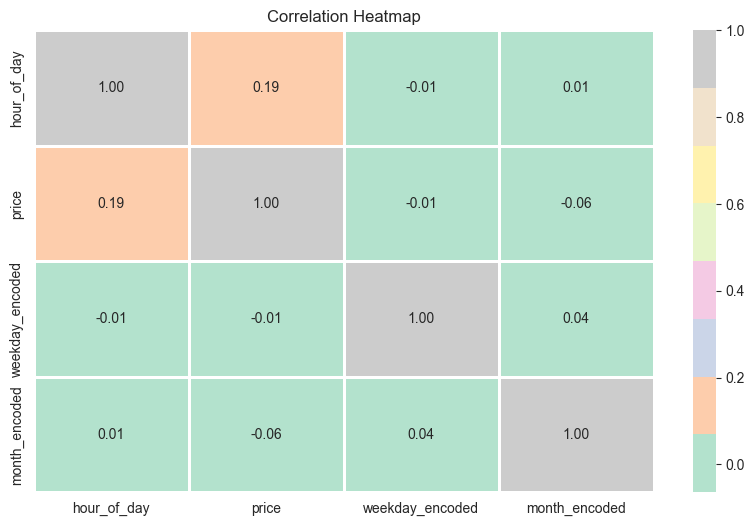

In [19]:
# Correlation Matrix for examining the correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()

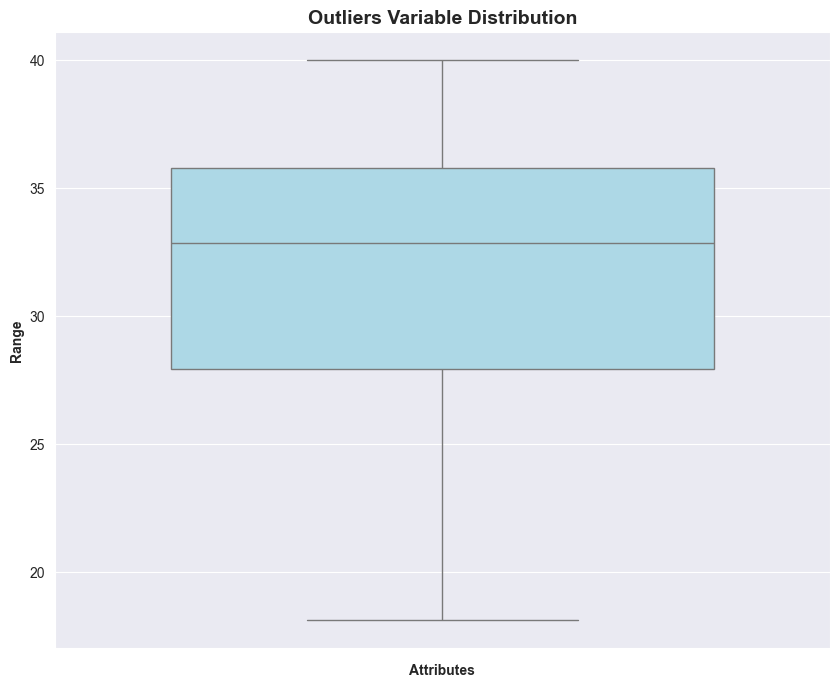

In [20]:
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['price'], orient="v", 
 color="lightblue", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');
plt.xticks(rotation=80); 

In [21]:
# Option 2: Use a loop for multiple columns
categorical_cols = df.select_dtypes('object')
label_encoders = {} 

for col in categorical_cols: 
    le = LabelEncoder() 
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for potential inverse transform

In [24]:
# Drop categorical columns
df.drop(df.select_dtypes(include=['object', 'category']), axis=1, inplace=True)

In [26]:
df1 = df.copy()

### Perform ML to the Imbalaced Data

In [27]:
df.head()

,hour_of_day,price,weekday_encoded,month_encoded,cash_type_encoded,coffee_name_encoded,time_of_day_encoded
0,10,38.7,5,3,0,7,1
1,12,38.7,5,3,0,6,0
2,12,38.7,5,3,0,6,0
3,13,28.9,5,3,0,0,0
4,13,38.7,5,3,0,7,0


## LinearRegression

Dataset shape: (3636, 6)
Feature names: Index(['hour_of_day', 'weekday_encoded', 'month_encoded', 'cash_type_encoded', 'coffee_name_encoded', 'time_of_day_encoded'], dtype='object')

X Train shape: (2908, 6)
Y Train shape: (2908,)
X Test shape: (728, 6)
Y Test shape: (728,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


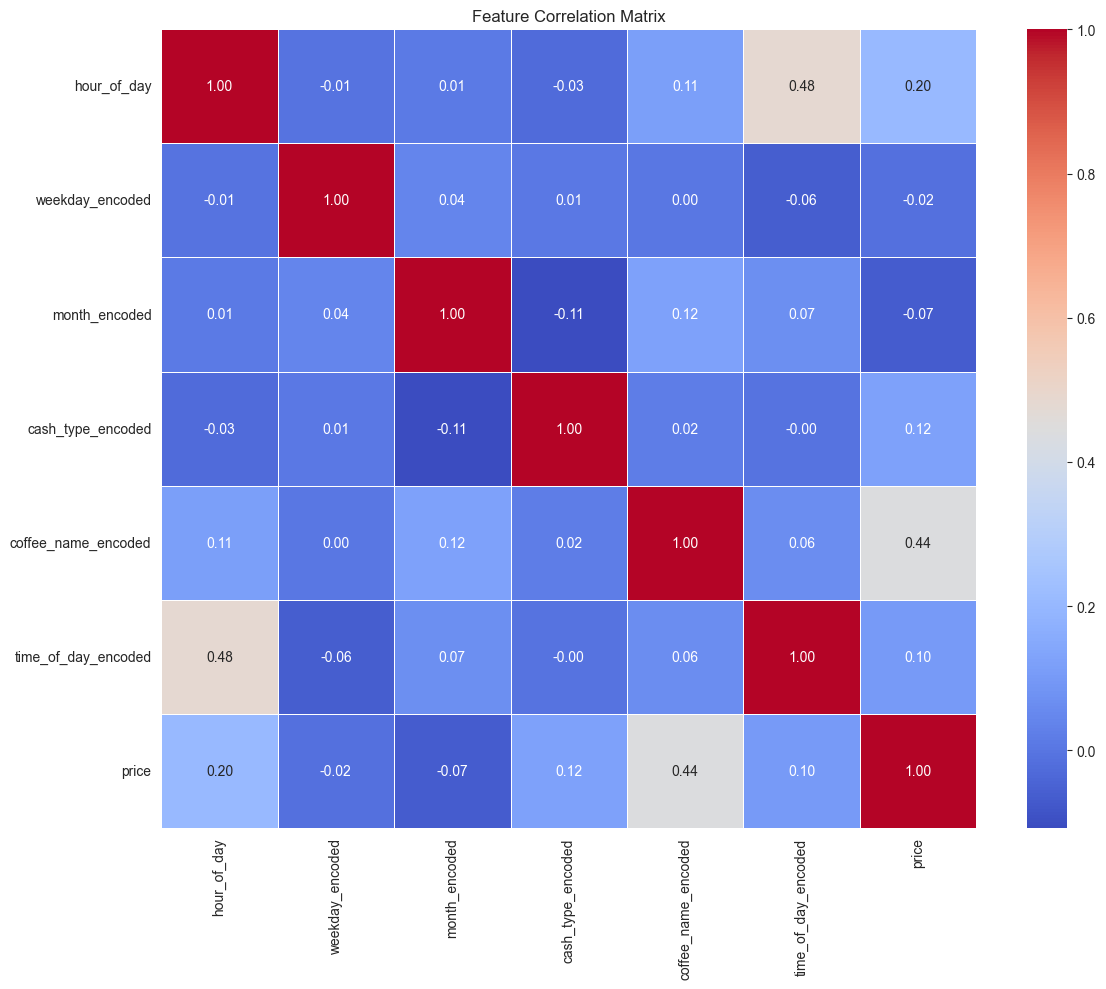

Feature correlation with target (price):
price                  1.000000
coffee_name_encoded    0.441801
hour_of_day            0.204247
cash_type_encoded      0.124637
time_of_day_encoded    0.100632
weekday_encoded       -0.016247
month_encoded         -0.065573
Name: price, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 18.3500 ± 0.9506
Cross-Validation MAE: 3.3243 ± 0.0332
Cross-Validation R²: 0.2388 ± 0.0342
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 18.4824
MSE train set: 18.2086

R² Score test: 0.2466
R² Score train: 0.2448

MAE test set: 3.3082
MAE train set: 3.3199

Coefficients: [ 0.17033384 -0.02769942 -0.15400122  3.471053    0.82265828  0.07623776]
Intercept: 27.639538649470907

Selected features: ['hour

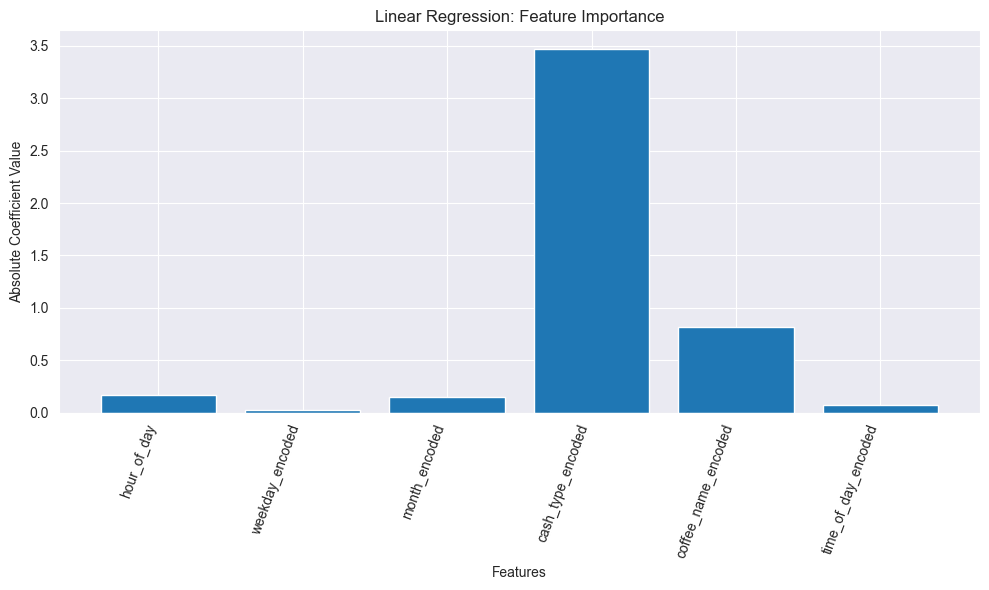

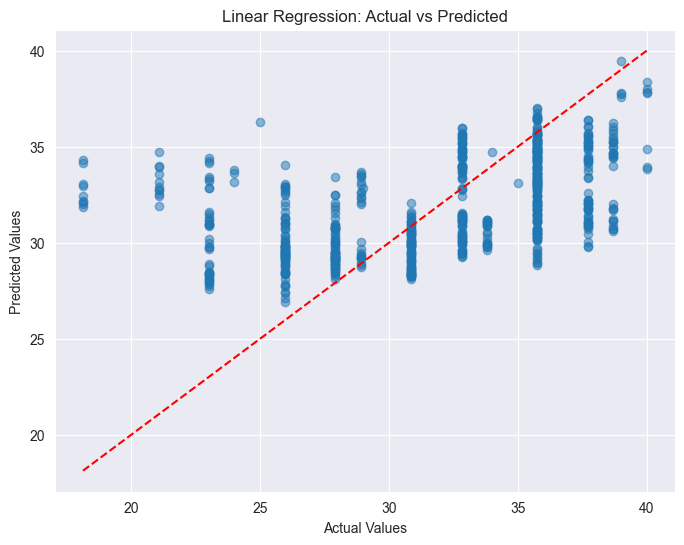

=== Scaled Linear Regression ===
MSE test set: 18.4824
MSE train set: 18.2086

R² Score test: 0.2466
R² Score train: 0.2448

MAE test set: 3.3082
MAE train set: 3.3199

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


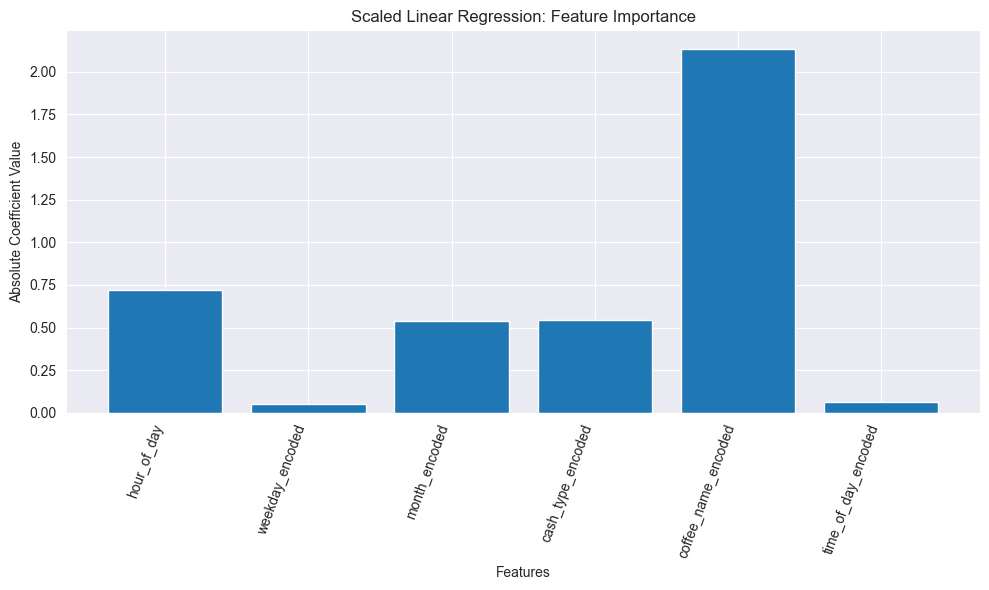

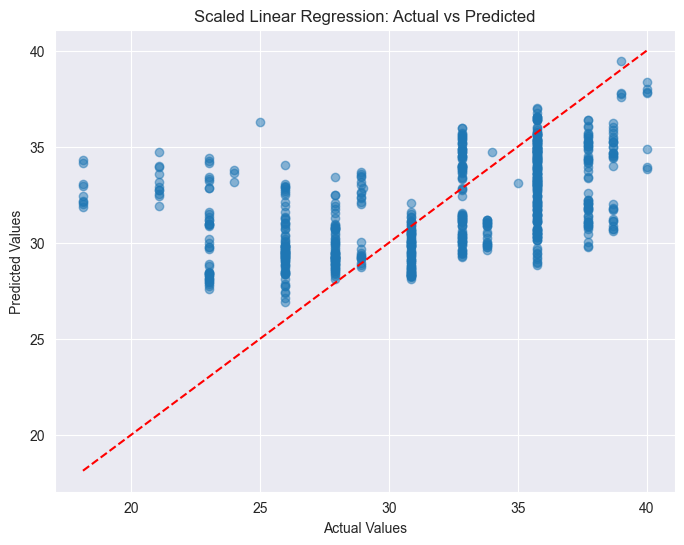

=== Feature Selection (SelectKBest) ===
MSE test set: 18.4731
MSE train set: 18.2115

R² Score test: 0.2470
R² Score train: 0.2446

MAE test set: 3.3072
MAE train set: 3.3193

Selected Features Selector : ['hour_of_day' 'month_encoded' 'cash_type_encoded' 'coffee_name_encoded'
 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


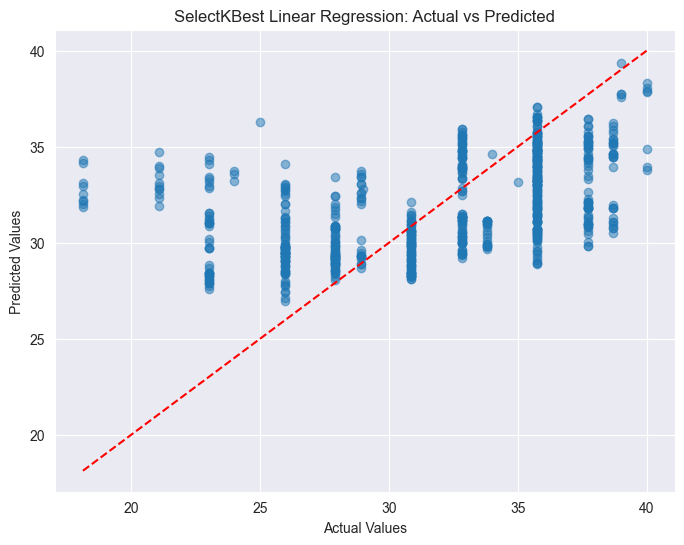

=== Feature Selection (RFE) ===
MSE test set: 18.4731
MSE train set: 18.2115

R² Score test: 0.2470
R² Score train: 0.2446

MAE test set: 3.3072
MAE train set: 3.3193

Selected Features Selector : ['hour_of_day' 'month_encoded' 'cash_type_encoded' 'coffee_name_encoded'
 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


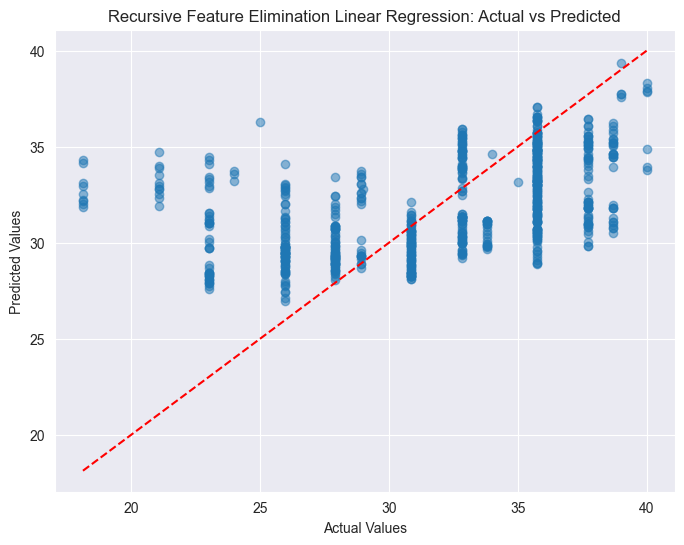

=== Polynomial Regression ===
MSE test set: 18.0733
MSE train set: 17.8474

R² Score test: 0.2633
R² Score train: 0.2597

MAE test set: 3.1975
MAE train set: 3.1941

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded' 'hour_of_day^2'
 'hour_of_day weekday_encoded' 'hour_of_day month_encoded'
 'hour_of_day cash_type_encoded' 'hour_of_day coffee_name_encoded'
 'hour_of_day time_of_day_encoded' 'weekday_encoded^2'
 'weekday_encoded month_encoded' 'weekday_encoded cash_type_encoded'
 'weekday_encoded coffee_name_encoded'
 'weekday_encoded time_of_day_encoded' 'month_encoded^2'
 'month_encoded cash_type_encoded' 'month_encoded coffee_name_encoded'
 'month_encoded time_of_day_encoded' 'cash_type_encoded^2'
 'cash_type_encoded coffee_name_encoded'
 'cash_type_encoded time_of_day_encoded' 'coffee_name_encoded^2'
 'coffee_name_encoded time_of_day_encoded' 'time_of_day_encoded^2']
-----------------------------

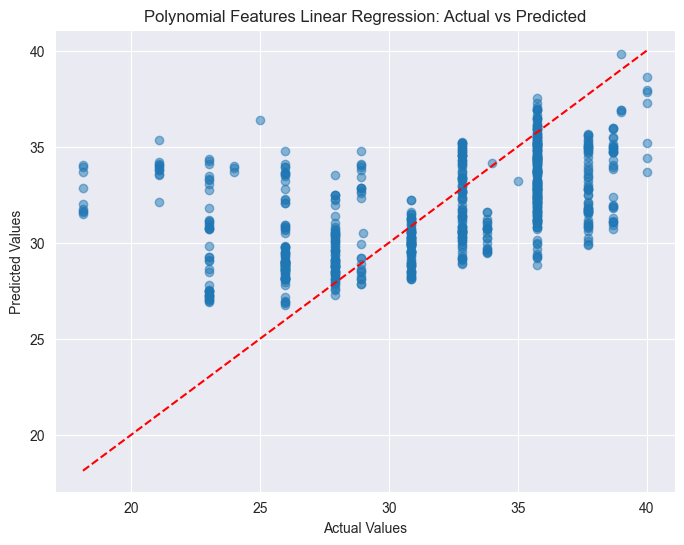

=== Ridge Regression ===
MSE test set:  18.4827
MSE train set: 18.2086

R² Score test: 0.2466
R² Score train:0.2448

MAE test set:  3.3095
MAE train set: 3.3214

Best alpha:    10.0000

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


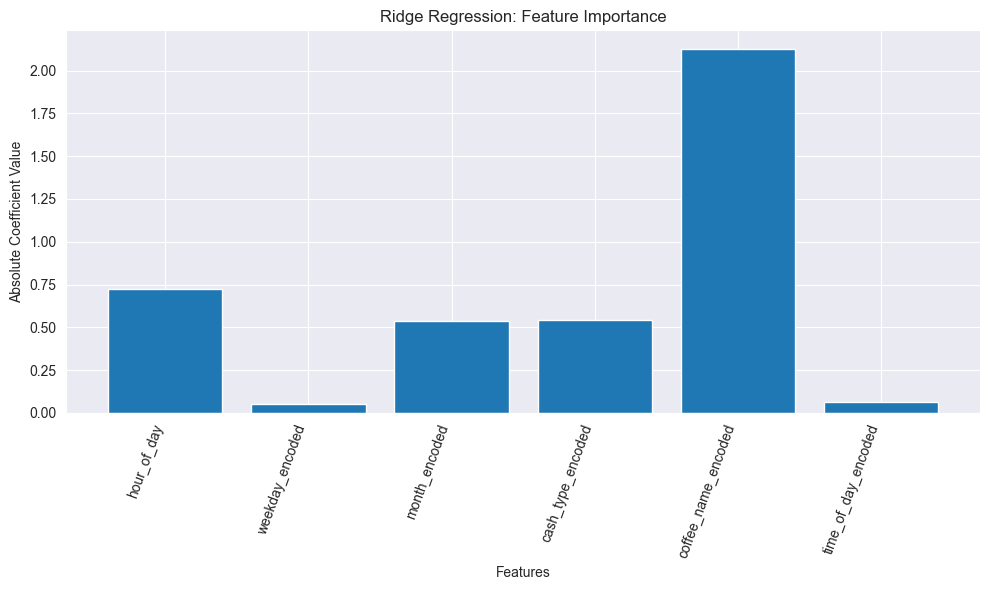

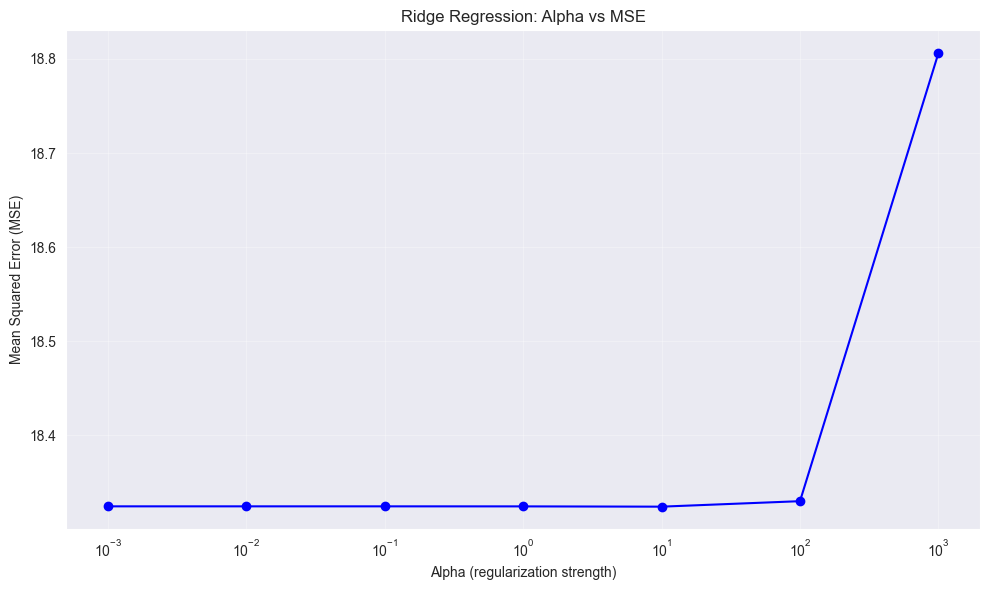

=== Lasso Regression ===
MSE test set: 18.4824
MSE train set: 18.2091

R² Score test: 0.2466
R² Score train: 0.2447

MAE test set: 3.3099
MAE train set: 3.3220

Best alpha: 0.01

Selected features: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


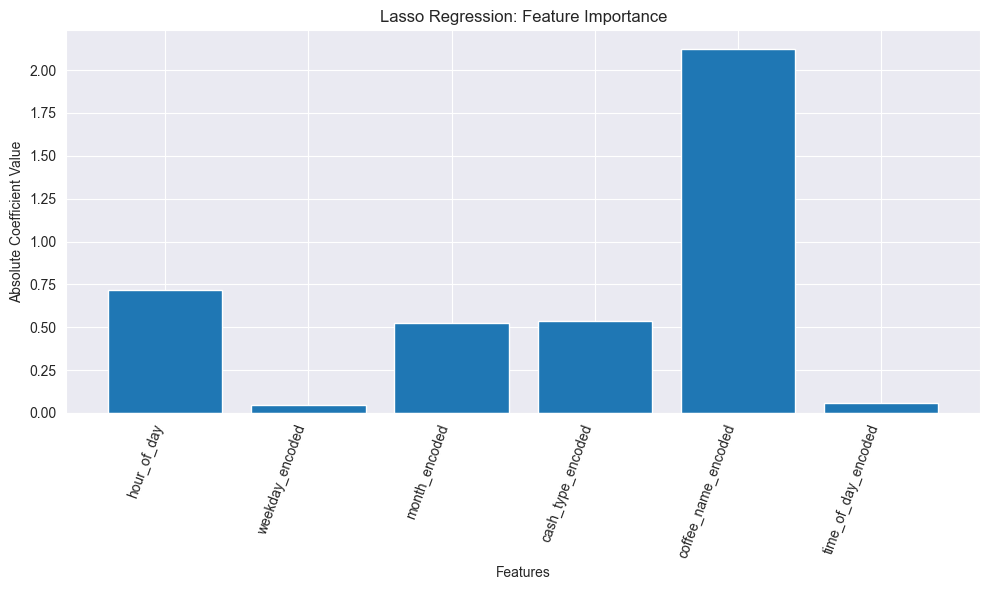

=== Elastic Net Regression ===
MSE test set: 18.4824
MSE train set: 18.2091

R² Score test: 0.2466
R² Score train: 0.2447

MAE test set: 3.3099
MAE train set: 3.3220

Best parameters: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.99}

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


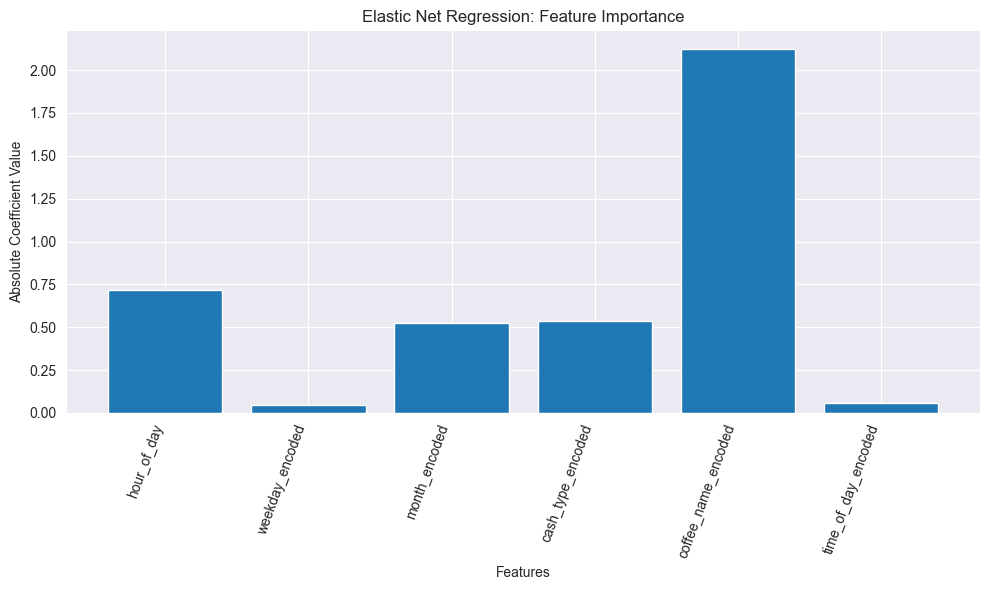

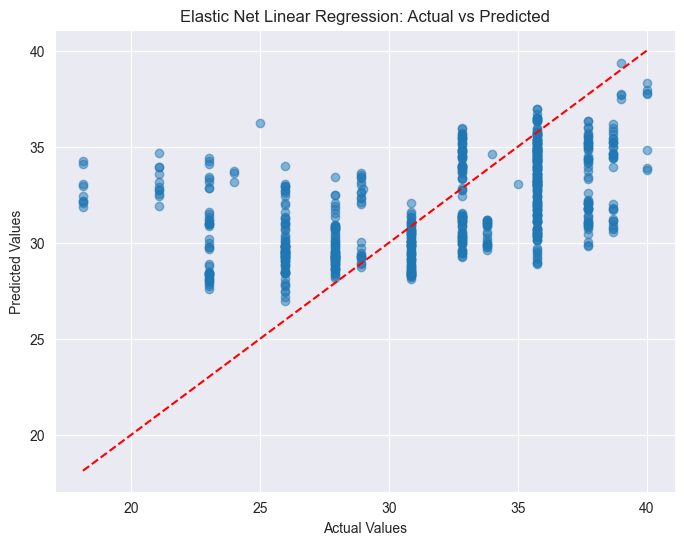

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                 MAE       MSE        R²
Ridge Regression           18.482717  0.246632  3.309535
Elastic Net                18.482417  0.246644  3.309921
Lasso Regression           18.482407  0.246645  3.309897
Basic Linear Regression    18.482353  0.246647  3.308158
Scaled Linear Regression   18.482353  0.246647  3.308158
Feature Selection (KBest)  18.473098  0.247024  3.307195
Feature Selection (RFE)    18.473098  0.247024  3.307195
Polynomial Regression      18.073262  0.263322  3.197487
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Ridge Regression
Best model according to MSE: Ridge Regression
Best model according to RMSE: Ridge Regression
Best model according to R2_score: Ridge Regression
----------------

In [29]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df.drop(columns=['price'], axis=1)
y = df['price']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['price'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['price'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (price):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

### Perform ML to the Balanced Data

In [30]:
df.head()

,hour_of_day,price,weekday_encoded,month_encoded,cash_type_encoded,coffee_name_encoded,time_of_day_encoded
0,10,38.7,5,3,0,7,1
1,12,38.7,5,3,0,6,0
2,12,38.7,5,3,0,6,0
3,13,28.9,5,3,0,0,0
4,13,38.7,5,3,0,7,0


In [31]:
df.shape

(3636, 7)

cash_type_encoded
0    3547
1      89
Name: count, dtype: int64


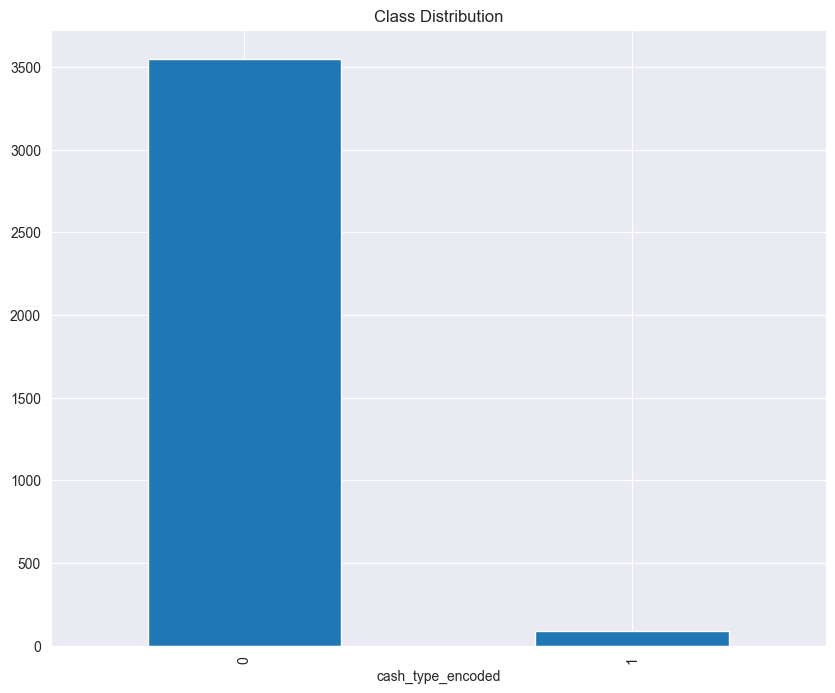

In [33]:
# Imbalance
# Visualize imbalance
print(df['cash_type_encoded'].value_counts())
df['cash_type_encoded'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

In [34]:
# Oversampling (Increase minority class)
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.cash_type_encoded == 0]
df_minority = df[df.cash_type_encoded == 1]

df_minority_upsampled = resample(df_minority, replace=True,   # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [37]:
# Always reset index (it’s a must to do)
df_balanced = df_balanced.reset_index(drop=True)

In [38]:
df_balanced

,hour_of_day,price,weekday_encoded,month_encoded,cash_type_encoded,coffee_name_encoded,time_of_day_encoded
0,10,38.7,5,3,0,7,1
1,12,38.7,5,3,0,6,0
2,12,38.7,5,3,0,6,0
3,13,28.9,5,3,0,0,0
4,13,38.7,5,3,0,7,0
...,...,...,...,...,...,...,...
7089,10,39.0,5,5,1,7,1
7090,17,39.0,2,5,1,2,2
7091,12,25.0,3,3,1,5,0
7092,17,39.0,6,5,1,7,2


cash_type_encoded
0    3547
1    3547
Name: count, dtype: int64


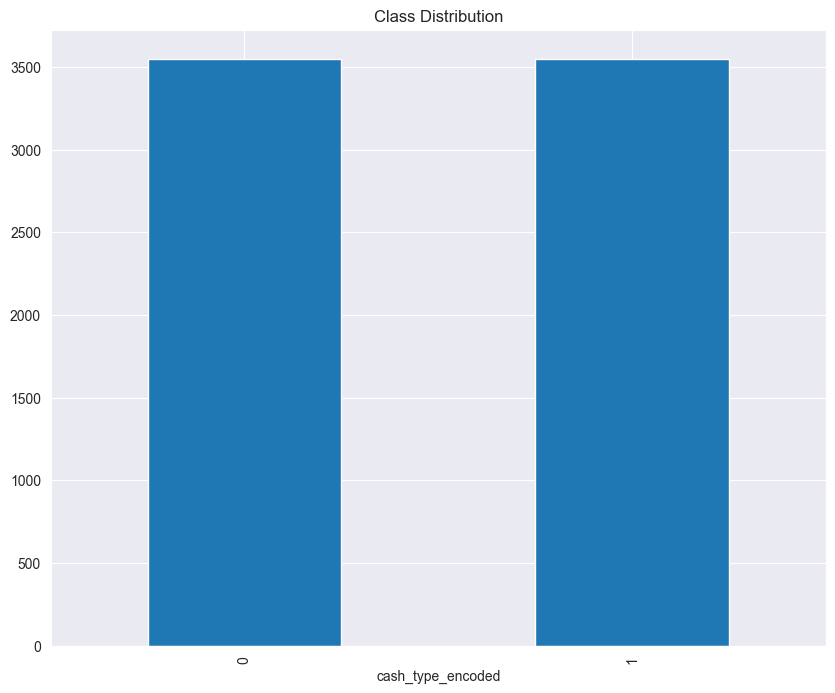

In [35]:
# Visualize imbalance
print(df_balanced['cash_type_encoded'].value_counts())
df_balanced['cash_type_encoded'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

In [40]:
df_balanced.head()

,hour_of_day,price,weekday_encoded,month_encoded,cash_type_encoded,coffee_name_encoded,time_of_day_encoded
0,10,38.7,5,3,0,7,1
1,12,38.7,5,3,0,6,0
2,12,38.7,5,3,0,6,0
3,13,28.9,5,3,0,0,0
4,13,38.7,5,3,0,7,0


Dataset shape: (7094, 6)
Feature names: Index(['hour_of_day', 'weekday_encoded', 'month_encoded', 'cash_type_encoded', 'coffee_name_encoded', 'time_of_day_encoded'], dtype='object')

X Train shape: (5675, 6)
Y Train shape: (5675,)
X Test shape: (1419, 6)
Y Test shape: (1419,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


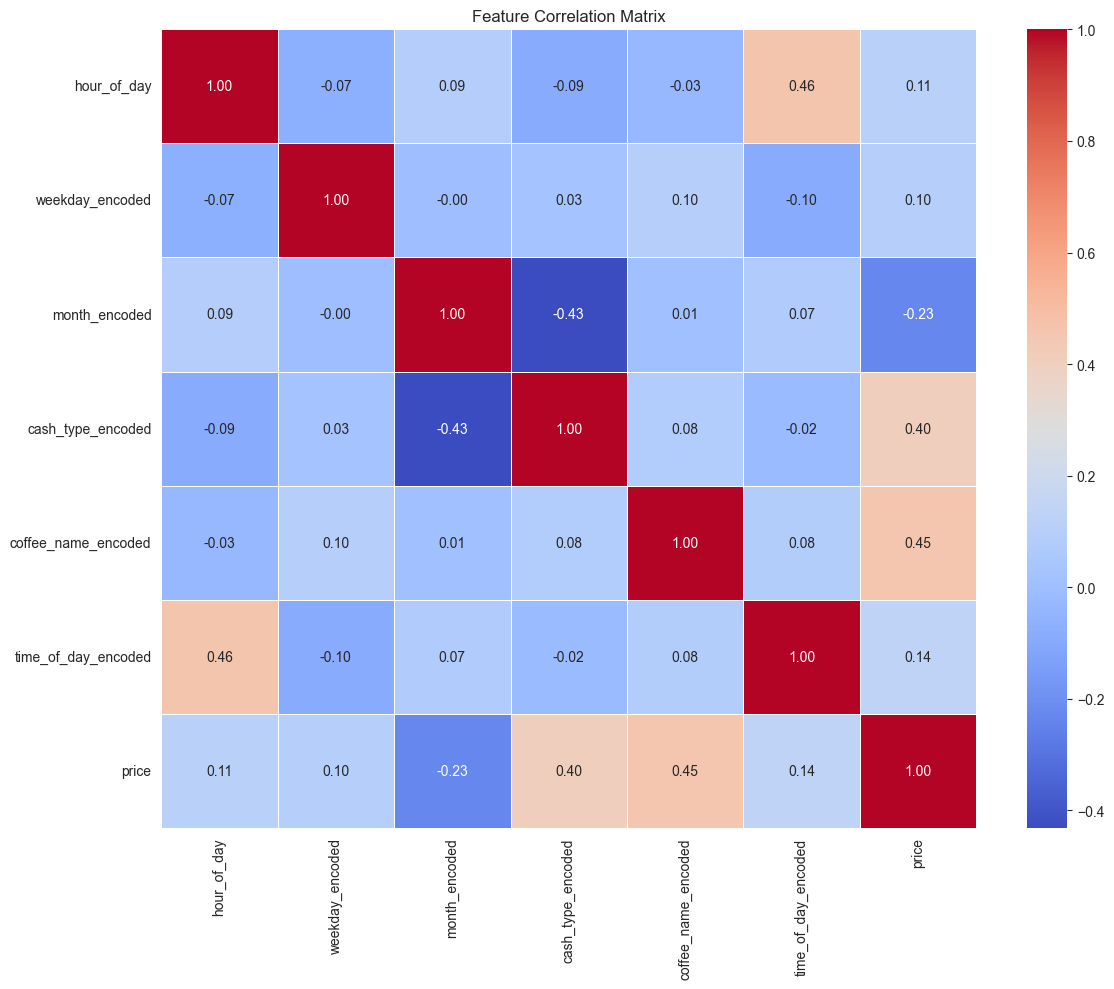

Feature correlation with target (price):
price                  1.000000
coffee_name_encoded    0.453643
cash_type_encoded      0.404509
time_of_day_encoded    0.138039
hour_of_day            0.107493
weekday_encoded        0.096532
month_encoded         -0.231797
Name: price, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 17.3537 ± 0.8921
Cross-Validation MAE: 3.1392 ± 0.0654
Cross-Validation R²: 0.3853 ± 0.0192
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 16.0010
MSE train set: 17.6614

R² Score test: 0.4093
R² Score train: 0.3804

MAE test set: 3.0539
MAE train set: 3.1737

Coefficients: [ 0.18056787  0.1472595  -0.20452023  3.58903906  0.84304072  0.39125087]
Intercept: 26.768550106097067

Selected features: ['hour

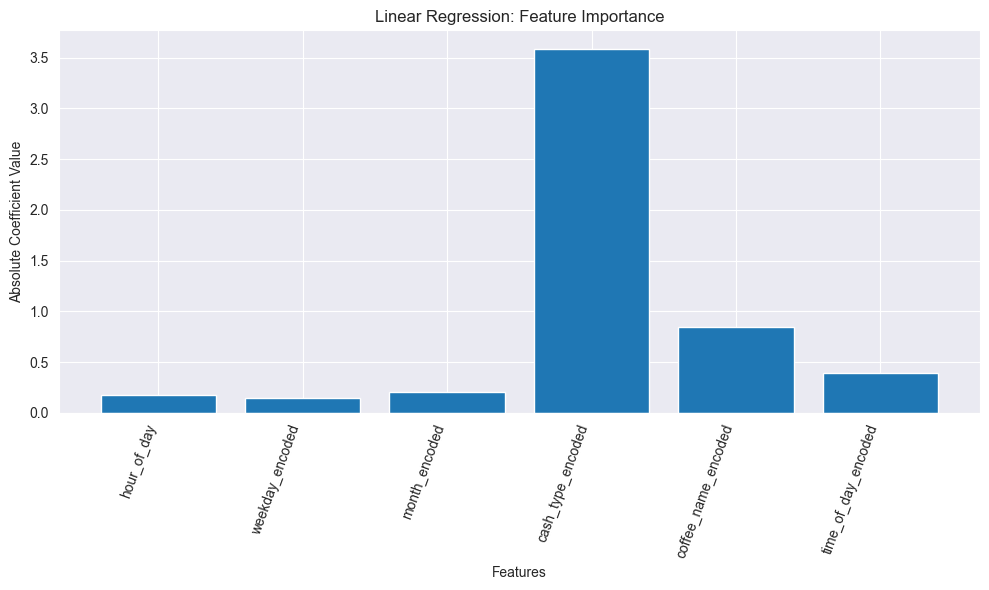

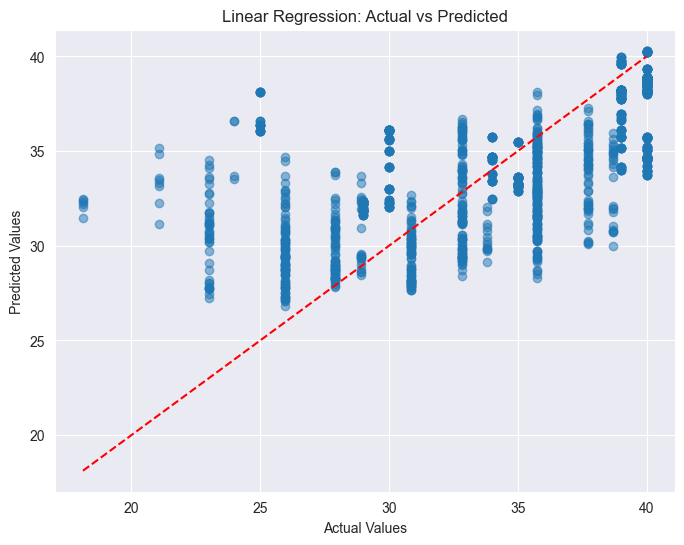

=== Scaled Linear Regression ===
MSE test set: 16.0010
MSE train set: 17.6614

R² Score test: 0.4093
R² Score train: 0.3804

MAE test set: 3.0539
MAE train set: 3.1737

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


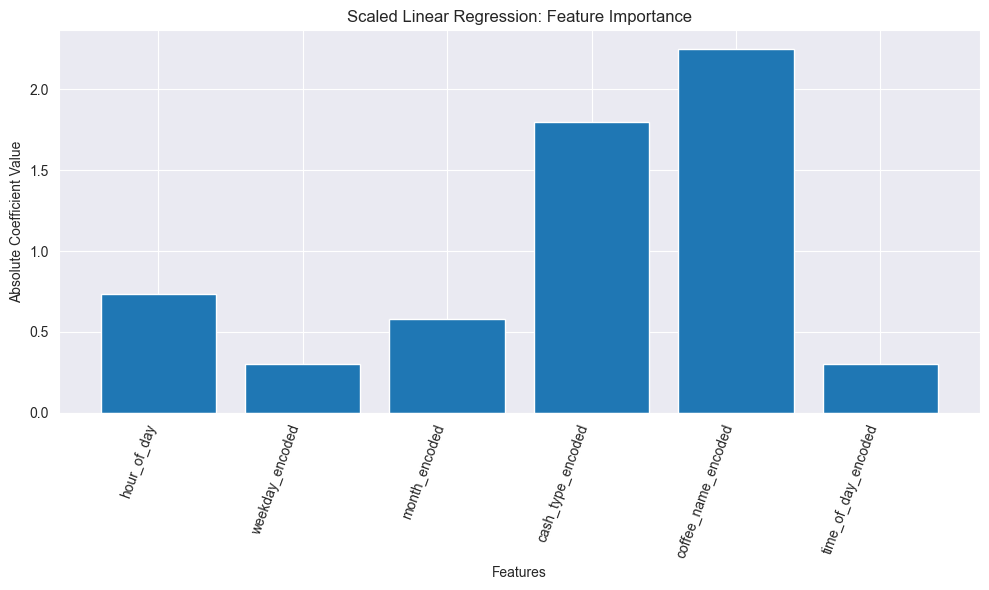

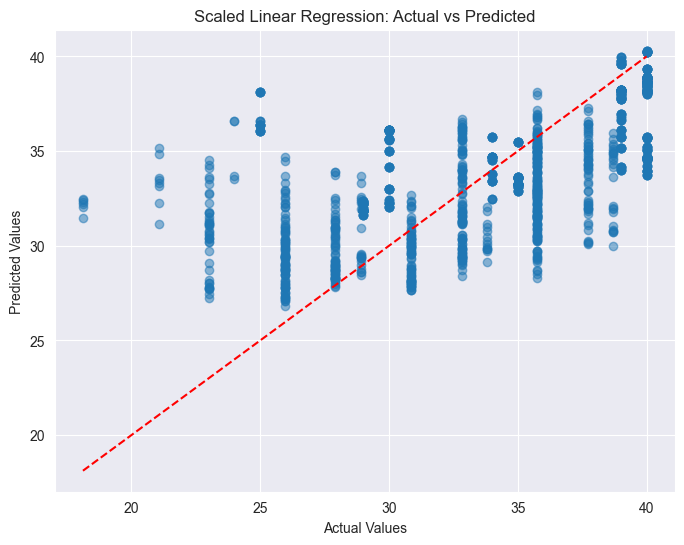

=== Feature Selection (SelectKBest) ===
MSE test set: 16.1573
MSE train set: 17.7517

R² Score test: 0.4036
R² Score train: 0.3772

MAE test set: 3.0753
MAE train set: 3.1951

Selected Features Selector : ['hour_of_day' 'month_encoded' 'cash_type_encoded' 'coffee_name_encoded'
 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


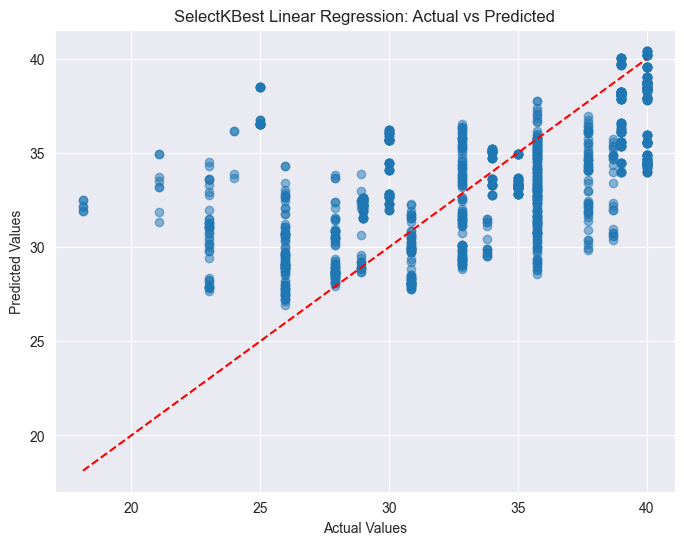

=== Feature Selection (RFE) ===
MSE test set: 16.1573
MSE train set: 17.7517

R² Score test: 0.4036
R² Score train: 0.3772

MAE test set: 3.0753
MAE train set: 3.1951

Selected Features Selector : ['hour_of_day' 'month_encoded' 'cash_type_encoded' 'coffee_name_encoded'
 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


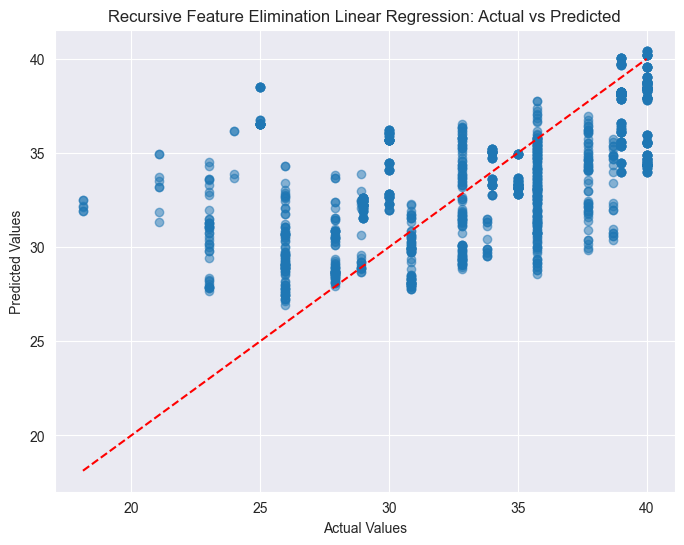

=== Polynomial Regression ===
MSE test set: 15.0577
MSE train set: 16.3143

R² Score test: 0.4442
R² Score train: 0.4277

MAE test set: 2.9178
MAE train set: 2.9757

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded' 'hour_of_day^2'
 'hour_of_day weekday_encoded' 'hour_of_day month_encoded'
 'hour_of_day cash_type_encoded' 'hour_of_day coffee_name_encoded'
 'hour_of_day time_of_day_encoded' 'weekday_encoded^2'
 'weekday_encoded month_encoded' 'weekday_encoded cash_type_encoded'
 'weekday_encoded coffee_name_encoded'
 'weekday_encoded time_of_day_encoded' 'month_encoded^2'
 'month_encoded cash_type_encoded' 'month_encoded coffee_name_encoded'
 'month_encoded time_of_day_encoded' 'cash_type_encoded^2'
 'cash_type_encoded coffee_name_encoded'
 'cash_type_encoded time_of_day_encoded' 'coffee_name_encoded^2'
 'coffee_name_encoded time_of_day_encoded' 'time_of_day_encoded^2']
-----------------------------

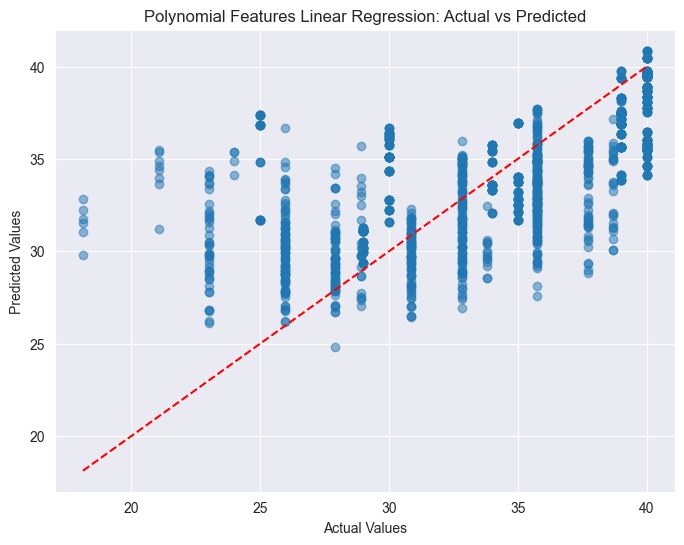

=== Ridge Regression ===
MSE test set:  16.0014
MSE train set: 17.6614

R² Score test: 0.4093
R² Score train:0.3804

MAE test set:  3.0548
MAE train set: 3.1747

Best alpha:    10.0000

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


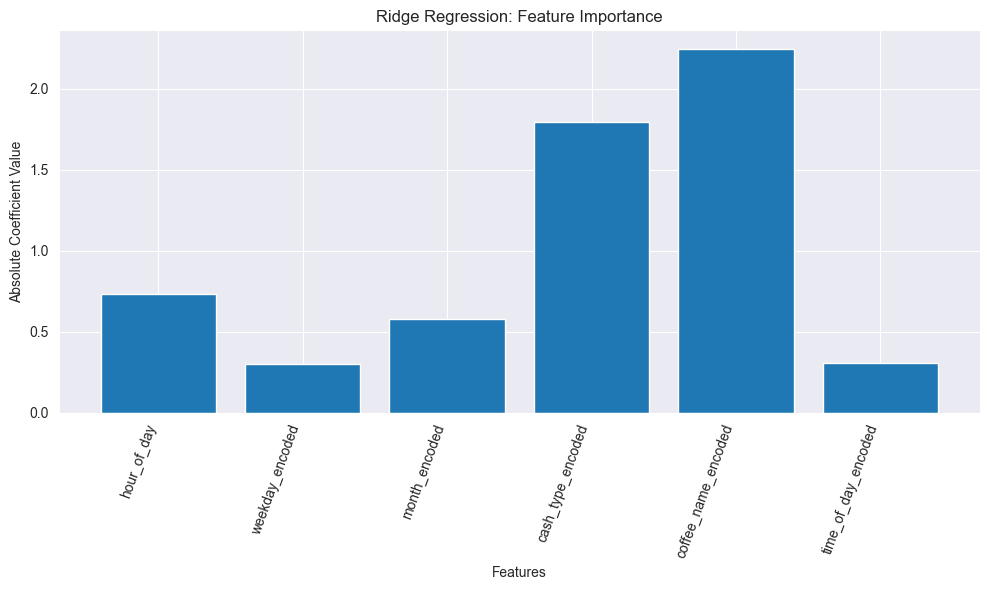

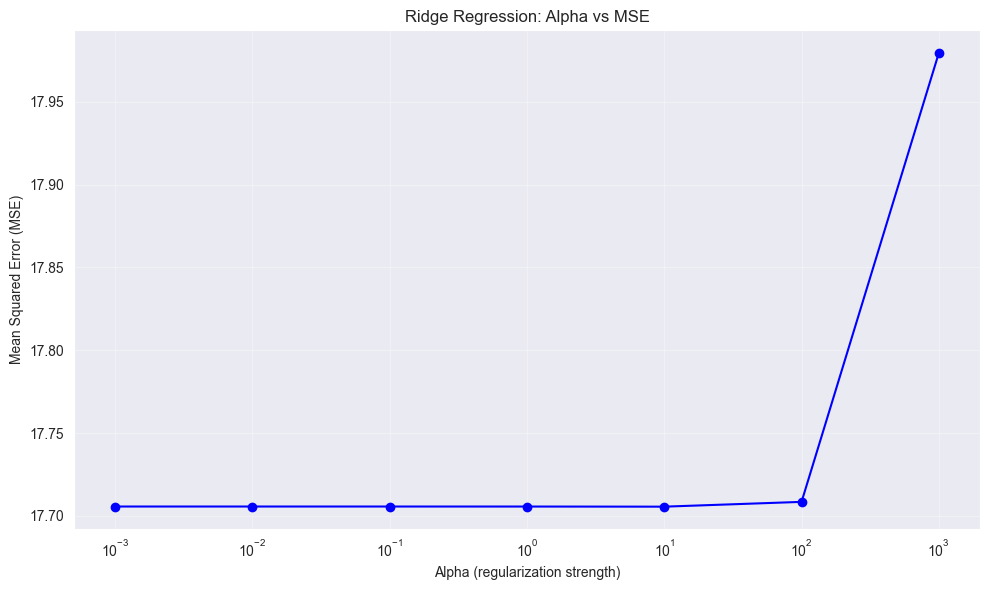

=== Lasso Regression ===
MSE test set: 16.0009
MSE train set: 17.6614

R² Score test: 0.4093
R² Score train: 0.3804

MAE test set: 3.0541
MAE train set: 3.1739

Best alpha: 0.001

Selected features: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


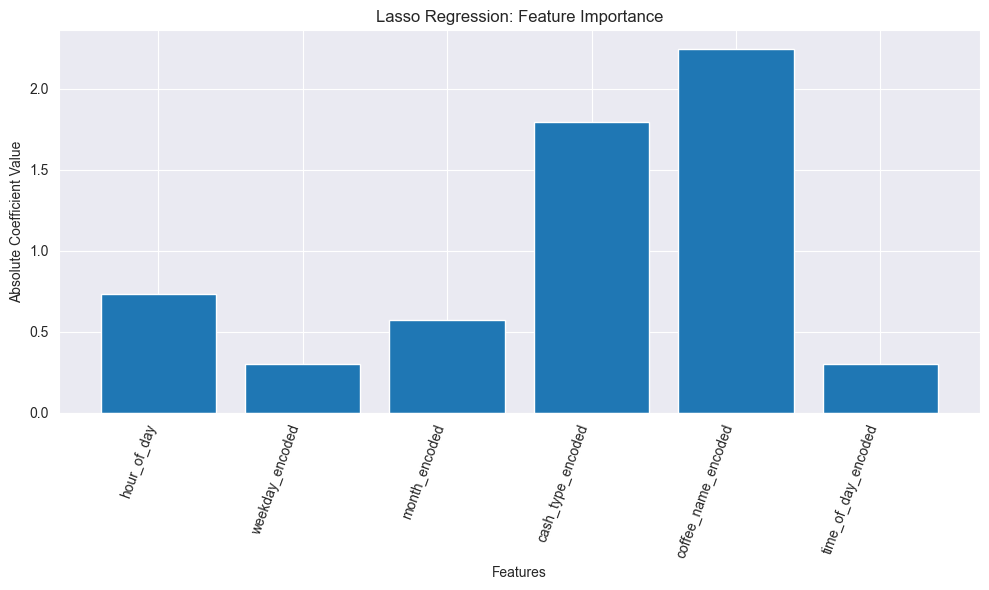

=== Elastic Net Regression ===
MSE test set: 16.0012
MSE train set: 17.6614

R² Score test: 0.4093
R² Score train: 0.3804

MAE test set: 3.0544
MAE train set: 3.1742

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}

Selected Features Coef_: ['hour_of_day' 'weekday_encoded' 'month_encoded' 'cash_type_encoded'
 'coffee_name_encoded' 'time_of_day_encoded']
-------------------------------------------------------------------------------------------------------------------------------


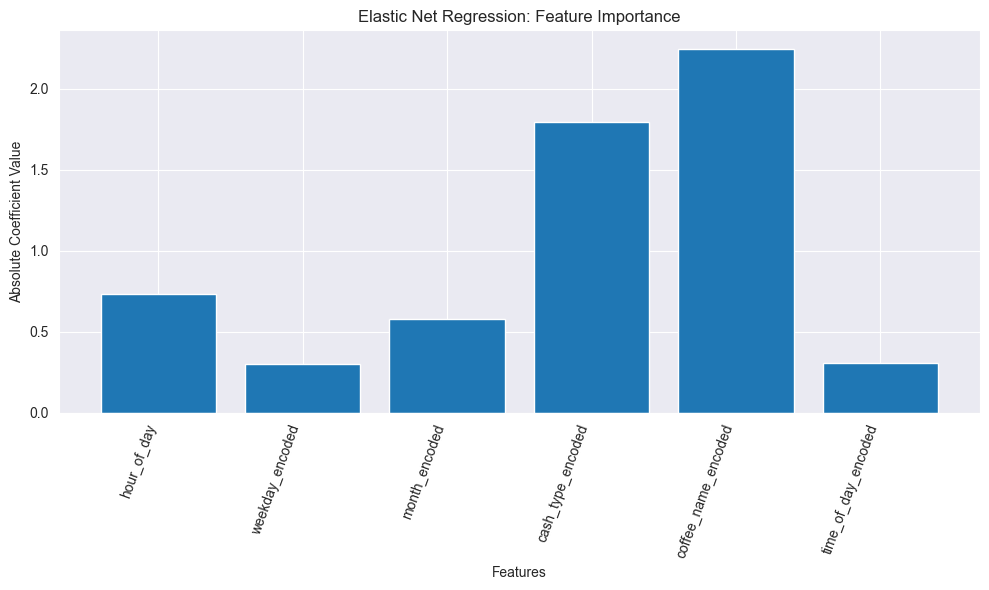

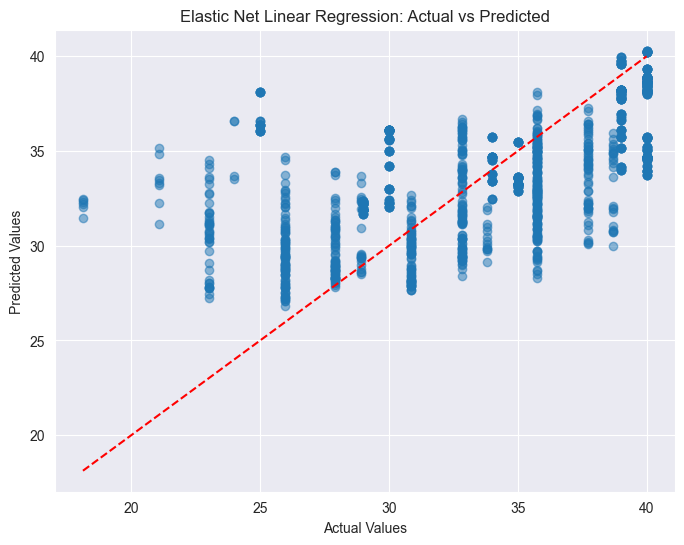

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                 MAE       MSE        R²
Feature Selection (KBest)  16.157280  0.403568  3.075324
Feature Selection (RFE)    16.157280  0.403568  3.075324
Ridge Regression           16.001431  0.409321  3.054783
Elastic Net                16.001195  0.409330  3.054361
Scaled Linear Regression   16.000983  0.409338  3.053880
Basic Linear Regression    16.000983  0.409338  3.053880
Lasso Regression           16.000868  0.409342  3.054068
Polynomial Regression      15.057667  0.444160  2.917805
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Feature Selection (KBest)
Best model according to MSE: Feature Selection (KBest)
Best model according to RMSE: Feature Selection (KBest)
Best model according to R2_score: Featur

In [41]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df_balanced.drop(columns=['price'], axis=1)
y = df_balanced['price']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df_balanced, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['price'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['price'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (price):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

In [45]:
print(f"The best model for Coffee Sales Dataset was {results.index[0]} with a Mean Squared Error of {results.iloc[0]['MSE']}")

The best model for Coffee Sales Dataset was Feature Selection (KBest) with a Mean Squared Error of 0.40356844251774815


In [42]:
df_balanced.head()

,hour_of_day,price,weekday_encoded,month_encoded,cash_type_encoded,coffee_name_encoded,time_of_day_encoded
0,10,38.7,5,3,0,7,1
1,12,38.7,5,3,0,6,0
2,12,38.7,5,3,0,6,0
3,13,28.9,5,3,0,0,0
4,13,38.7,5,3,0,7,0


Dataset shape: (7094, 6)
Feature names: Index(['hour_of_day', 'price', 'weekday_encoded', 'month_encoded', 'coffee_name_encoded', 'time_of_day_encoded'], dtype='object')
Number of classes: 2
Class distribution: [3547 3547]

X Train shape: (5675, 6)
Y Train shape: (5675,)
X Test shape: (1419, 6)
Y Test shape: (1419,)
-------------------------------------------------------------------------------------------------------------------------------
--- Basic Model Performance ---
Accuracy test set: 0.7378
Accuracy train set: 0.7218

Classification Report:
Classification Report test set:
               precision    recall  f1-score   support

           0       0.77      0.70      0.73       725
           1       0.71      0.78      0.74       694

    accuracy                           0.74      1419
   macro avg       0.74      0.74      0.74      1419
weighted avg       0.74      0.74      0.74      1419


Classification Report train set:
               precision    recall  f1-score   supp

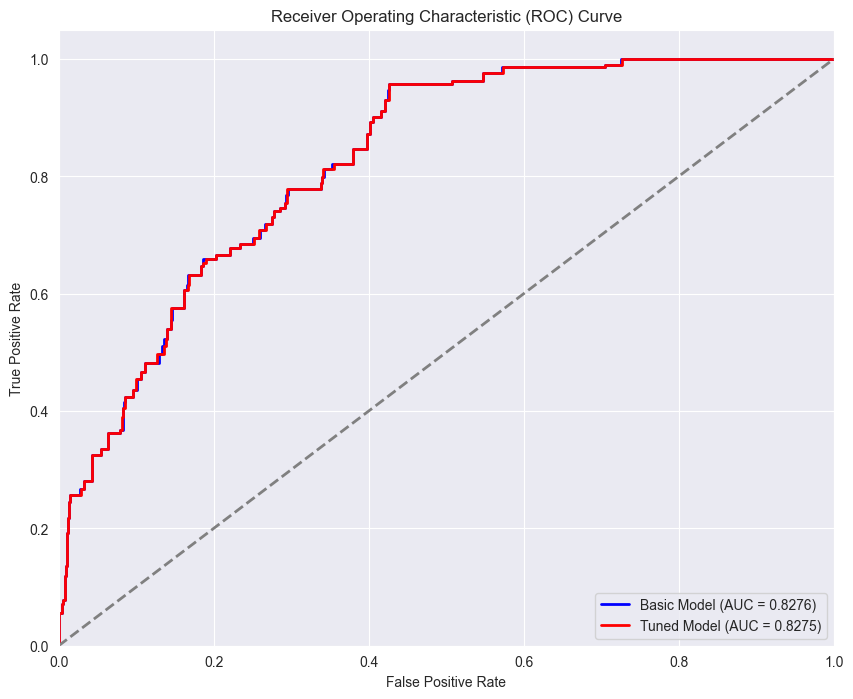

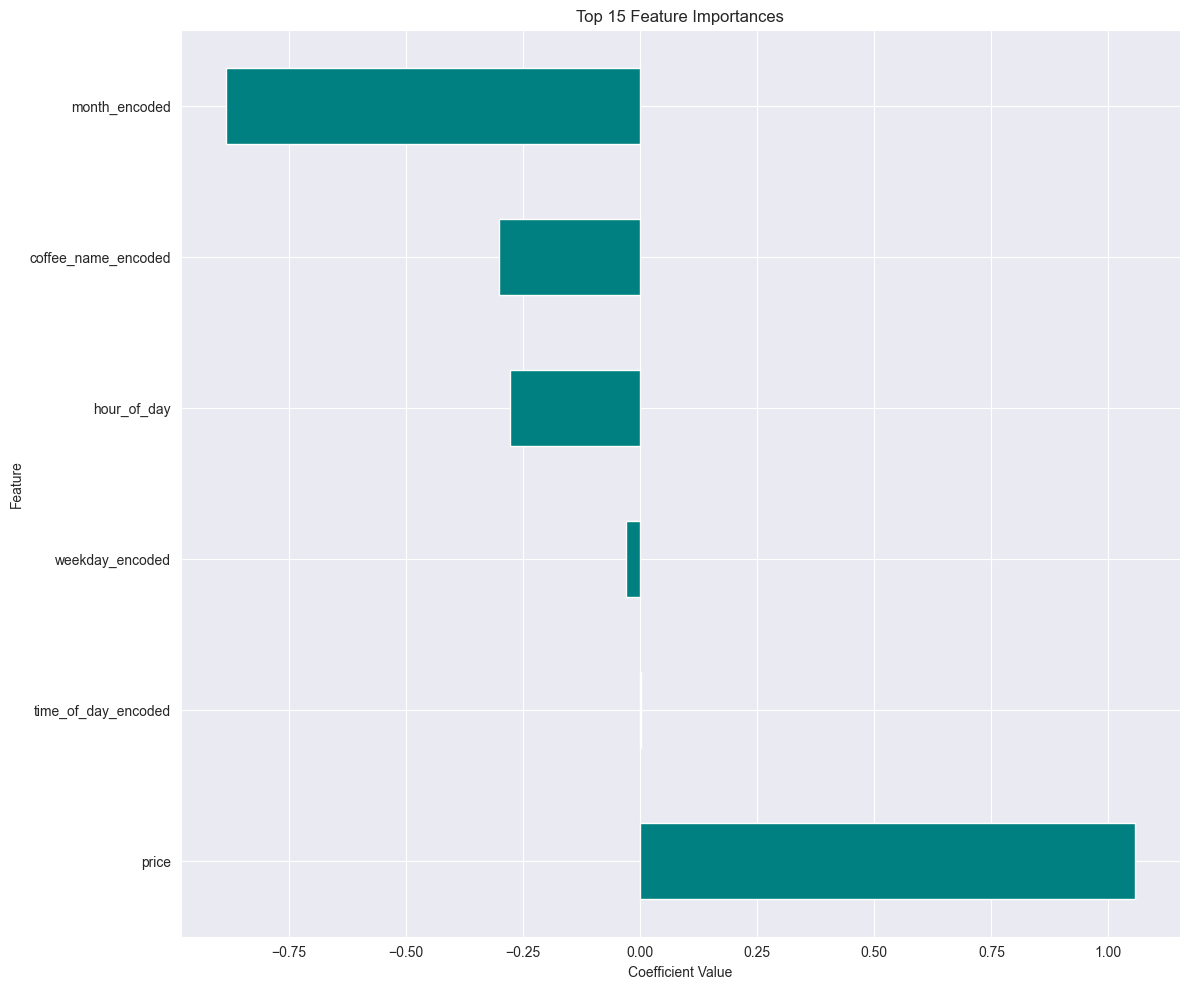

--- Top 10 Most Important Features ---
                     Coefficient
price                   1.055936
time_of_day_encoded     0.002349
weekday_encoded        -0.031481
hour_of_day            -0.279066
coffee_name_encoded    -0.301248
month_encoded          -0.884645
--- Bottom 10 Least Important Features ---
                     Coefficient
price                   1.055936
time_of_day_encoded     0.002349
weekday_encoded        -0.031481
hour_of_day            -0.279066
coffee_name_encoded    -0.301248
month_encoded          -0.884645
-------------------------------------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/py

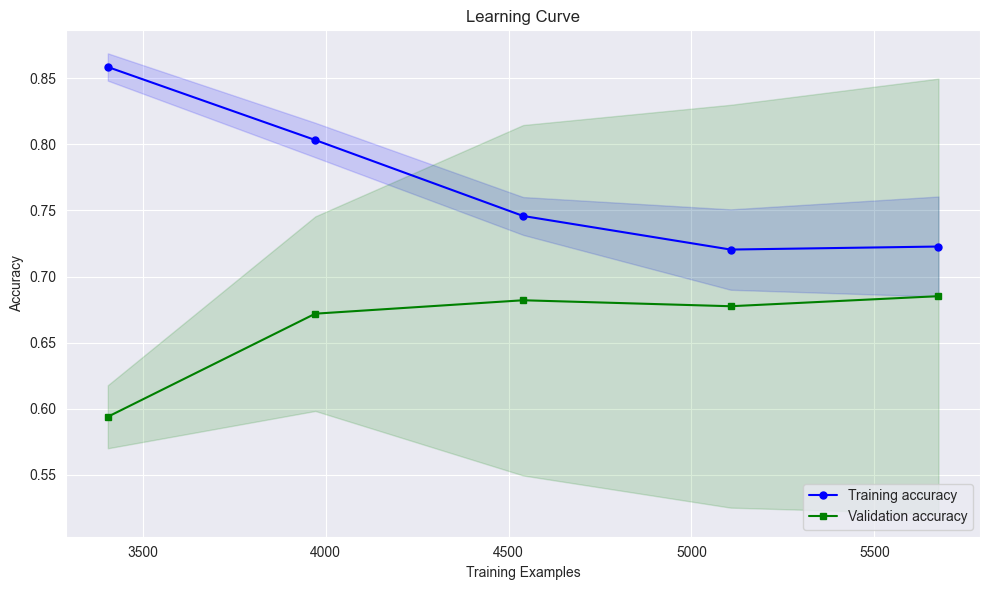

,hour_of_day,price,weekday_encoded,month_encoded,coffee_name_encoded,time_of_day_encoded,prediction
7057,15,40.00,5,4,7,0,1
5724,10,40.00,2,3,7,1,1
2887,14,35.76,4,2,2,0,1
3846,9,29.00,2,5,0,1,0
1172,14,32.82,2,8,7,0,0


,hour_of_day,price,weekday_encoded,month_encoded,coffee_name_encoded,time_of_day_encoded,prediction
7057,15,40.00,5,4,7,0,1
5724,10,40.00,2,3,7,1,1
2887,14,35.76,4,2,2,0,1
3846,9,29.00,2,5,0,1,0
1172,14,32.82,2,8,7,0,0


,hour_of_day,price,weekday_encoded,month_encoded,coffee_name_encoded,time_of_day_encoded,prediction
7057,15,40.00,5,4,7,0,1
5724,10,40.00,2,3,7,1,1
2887,14,35.76,4,2,2,0,1
3846,9,29.00,2,5,0,1,0
1172,14,32.82,2,8,7,0,0


In [43]:
# Logistic Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (binary classification)
X = df_balanced.drop(columns=['cash_type_encoded'], axis=1)
y = df_balanced['cash_type_encoded']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

feature_names = X_train.columns  # or X.columns
target_names = y_train.values # or y.values 

# Basic model with default parameters 
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_train_lr = lr.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance ---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train_lr):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_lr)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train_lr)}")
print("-" * 127)  

# Basic model with default parameters using pipeline
# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', LogisticRegression(random_state=42))  # Logistic regression model
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance Using Pipeline---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_pipeline)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train)}")

# Display confusion matrix
print("—- Confusion Matrix: -—")
print(f"Confusion Matrix test set:\n {confusion_matrix(y_test, y_pred_pipeline)}\n")
print(f"Confusion Matrix train set:\n {confusion_matrix(y_train, y_pred_train)}")
print("-" * 127)  

# Hyperparameter tuning with GridSearchCV
print("--- Model With Hyperparameter Tuning ---")
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Algorithm to use
    'classifier__max_iter': [1000, 5000, 10000],      # Max iterations
    'classifier__class_weight': [None, 'balanced']  # Class weighting
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}\n")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print("-" * 127)  

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_pred_tuned_train = best_model.predict(X_train)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

print("--- Tuned Model Performance ---")
print(f"Accuracy Tuned Test: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Accuracy Tuned Train: {accuracy_score(y_train, y_pred_tuned_train):.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_tuned),'\n')
print(classification_report(y_train, y_pred_tuned_train))
print("-" * 127)   

# Compare basic and tuned models
print("--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Basic Model Accuracy Pipeline: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Tuned Model Accuracy GridSearch: {accuracy_score(y_test, y_pred_tuned):.4f}\n")

# Calculate cross-validation scores for both models
cv_scores_basic_lr = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
cv_scores_basic_pipe = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_grid = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_lr}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_pipe}")
print(f"Tuned Model GrdiSearch Cross-Validation Scores: {cv_scores_tuned_grid}\n")

print(f"Basic Model Average CV Score LR:   {cv_scores_basic_lr.mean():.4f} ± {cv_scores_basic_lr.std():.4f}")
print(f"Basic Model Average CV Score Pipe: {cv_scores_basic_pipe.mean():.4f} ± {cv_scores_basic_pipe.std():.4f}")
print(f"Tuned Model Average CV Score Grid: {cv_scores_tuned_grid.mean():.4f} ± {cv_scores_tuned_grid.std():.4f}")
print("-" * 127)  

# Plot ROC curve
plt.figure(figsize=(10, 8))

# Calculate ROC curve for basic model using pipeline 
y_prob_basic = pipeline.predict_proba(X_test)[:, 1]
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_prob_basic)
roc_auc_basic = auc(fpr_basic, tpr_basic)

# Calculate ROC curve for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot both curves
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'Basic Model (AUC = {roc_auc_basic:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='red', lw=2, label=f'Tuned Model (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('roc_curve_comparison.png')
#plt.close() 
plt.show()

# Feature importance
final_model = best_model.named_steps['classifier']
if hasattr(final_model, 'coef_'):
    # Get feature importances (coefficients)
    importances = pd.DataFrame(
        final_model.coef_[0],
        index=X_train.columns,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_features = importances.head(15)
    top_features['Coefficient'].plot(kind='barh', color='teal')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('feature_importance.png')
    #plt.close()
    plt.show()
    
    print("--- Top 10 Most Important Features ---")
    print(importances.head(10))
    print("--- Bottom 10 Least Important Features ---")
    print(importances.tail(10))
    print("-" * 127)  

# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('learning_curve.png')
#plt.close()
plt.show()

# Dataframe Predicted
base_model_df = pd.DataFrame(X_test)
base_model_df['prediction'] = np.round(y_pred_lr, 3)
display(base_model_df.head())

grid_model_df = pd.DataFrame(X_test)
grid_model_df['prediction'] = np.round(y_pred_tuned, 3)
display(grid_model_df.head())

pipe_model_df = pd.DataFrame(X_test)
pipe_model_df['prediction'] = np.round(y_pred_pipeline, 3)
display(pipe_model_df.head()) 

### In classification models every model gave the same result